# Bond curves

Electronic energies of dimers with respect to the bond length.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams['font.size'] = 12

from apdft_tools.utils import *
from apdft_tools.utils import _remove_dimer_outliers, _dimer_poly_pred
from apdft_tools.data import prepare_dfs
from apdft_tools.prediction import *

json_path = '../../json-data/dimer-pyscf.apdft-data.posthf.json'
df_qc, df_apdft = prepare_dfs(json_path, get_CBS=False)

## System and plot specifications

In [2]:
system_label = 'o.h'
charge = 0  # Initial charge of the system.
excitation_level = 0

basis_set = 'cc-pV5Z'
specific_atom = 0
n_points = 2
poly_order = 4

qm_color = '#577590'
apdft_colors = ["#F94144", "#F8961E", "#43AA8B"]

## Bond curve with QC data

(-0.9756929867910821, 10.168393083954344)

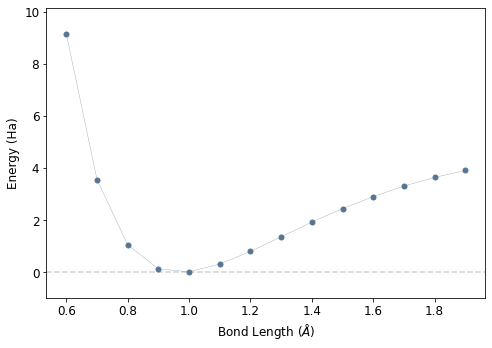

In [3]:
# Reference QC data
df_qc_system = df_qc.query(
    'system == @system_label'
    '& charge == @charge'
    '& lambda_value == 0'
)
sys_multiplicity = get_multiplicity(df_qc_system, excitation_level)
df_qc_system = df_qc_system.query('multiplicity == @sys_multiplicity')
target_n_electrons = df_qc_system.iloc[0]['n_electrons']
target_atomic_numbers = df_qc_system.iloc[0]['atomic_numbers']


qc_system_bl, qc_system_e = get_dimer_curve(df_qc_system, lambda_value=0)

qc_eq_bl, qc_eq_e = get_dimer_minimum(
    qc_system_bl,qc_system_e, n_points=n_points, poly_order=poly_order,
)

###   FIGURE   ###
# Plots the QC bond length curve.

fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.patch.set_facecolor('white')

ax.plot(
    qc_system_bl, hartree_to_ev(qc_system_e - qc_eq_e),
    marker='o', markersize=5,
    linewidth=0.25, color=qm_color
)

ax.axhline(0, 0, 2, color='dimgrey', alpha=0.3, linestyle='--', zorder=0)

ax.set_xlabel('Bond Length ($\AA$)')

ylim_buffer = 1
ax.set_ylabel('Energy (Ha)')
ax.set_ylim(
    (min(hartree_to_ev(qc_system_e-qc_eq_e))-ylim_buffer, max(hartree_to_ev(qc_system_e-qc_eq_e))+ylim_buffer)
)


## Bond curve with all APDFT references

QC bond length: 0.968 A
-------------------
APDFT from n.h: 0.967 A (error = -0.000)
APDFT from f.h: 0.967 A (error = -0.000)
APDFT from ne.h: 0.966 A (error = -0.002)


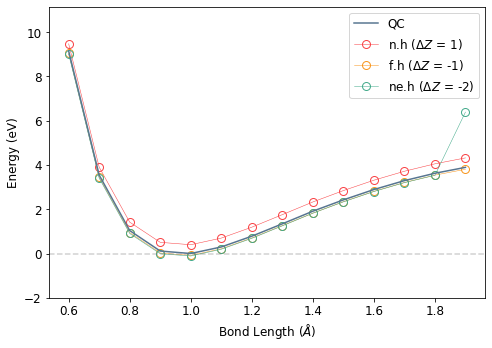

In [4]:
use_fin_diff = False
apdft_order = 2

# APDFT predictions with or without Taylor series.
if use_fin_diff:
    df_selection = 'apdft'
else:
    df_selection = 'qc'
df_references = get_apdft_refs(
    df_qc, df_apdft, system_label, target_n_electrons, basis_set=basis_set, df_selection=df_selection,
    excitation_level=excitation_level, specific_atom=specific_atom
)
ref_systems = tuple(set(df_references['system']))

pred_system_bl = np.zeros((len(ref_systems), len(qc_system_bl)))
pred_system_e = np.zeros((len(ref_systems), len(qc_system_bl)))
pred_lambda_values = np.zeros(len(ref_systems))
pred_eq_bond_lengths = np.zeros(len(ref_systems))
pred_eq_energies = np.zeros(len(ref_systems))

for i in range(len(ref_systems)):
    sys_label = ref_systems[i]
    df_ref_sys = df_references.query('system == @sys_label')
    ref_atomic_numbers = df_ref_sys.iloc[0]['atomic_numbers']
    ref_lambda_value = get_lambda_value(
        ref_atomic_numbers, target_atomic_numbers, specific_atom=specific_atom
    )
    pred_lambda_values[i] = round(ref_lambda_value)
    if use_fin_diff:
        pred_system_bl[i], pred_system_e[i] = get_dimer_curve(
            df_ref_sys, lambda_value=ref_lambda_value, use_fin_diff=use_fin_diff, apdft_order=apdft_order
        )
    else:
        pred_system_bl[i], pred_system_e[i] = get_dimer_curve(
            df_ref_sys, lambda_value=ref_lambda_value, use_fin_diff=use_fin_diff
        )
    pred_eq_bond_lengths[i], pred_eq_energies[i] = get_dimer_minimum(
        pred_system_bl[i], pred_system_e[i], n_points=n_points, poly_order=poly_order,
    )


print(f'QC bond length: {qc_eq_bl:.3f} A')
print('-------------------')
for i in range(len(ref_systems)):
    print(f'APDFT from {ref_systems[i]}: {pred_eq_bond_lengths[i]:.3f} A (error = {(pred_eq_bond_lengths[i] - qc_eq_bl):.3f})')

###   FIGURE   ###
# Plots the QC bond length curve.

fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.patch.set_facecolor('white')

e_0 = min(qc_system_e)

ax.plot(
    qc_system_bl, hartree_to_ev(qc_system_e - e_0),
    marker='', markersize=5,
    linewidth=1.5, color=qm_color, label='QC'
)
for i in range(len(ref_systems)):
    label = f'{ref_systems[i]} ($\Delta Z$ = {round(pred_lambda_values[i])})'
    ax.plot(
        pred_system_bl[i], hartree_to_ev(pred_system_e[i] - e_0),
        marker='o', markersize=8, fillstyle='none',
        linewidth=0.5, color=apdft_colors[i], label=label,
        zorder=0
    )

ax.axhline(0, 0, 2, color='dimgrey', alpha=0.3, linestyle='--', zorder=0)

ax.set_xlabel('Bond Length ($\AA$)')

ylim_buffer = 2
ax.set_ylabel('Energy (eV)')
ax.set_ylim((min(hartree_to_ev(qc_system_e-e_0))-ylim_buffer, max(hartree_to_ev(qc_system_e-e_0))+ylim_buffer))

ax.legend()